In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import kagglehub

In [4]:
path = kagglehub.dataset_download("tsaideepak/skin-cancer")
print(path)


100%|██████████| 462M/462M [00:03<00:00, 128MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/tsaideepak/skin-cancer/versions/1


#The directories in train and validate-

akiec → Actinic Keratoses / Intraepithelial Carcinoma
• Precancerous / early malignant

bcc → Basal Cell Carcinoma
• Malignant (skin cancer)

bkl → Benign Keratosis-like Lesions
• Benign (non-cancerous)

df → Dermatofibroma
• Benign

mel → Melanoma
• Highly malignant (most dangerous)

nv → Melanocytic Nevus
• Benign (common mole)

vasc → Vascular Lesions
• Usually benign

In [5]:
base_path = path  # from kagglehub
train_path = os.path.join(base_path, "datatree", "train")
val_path = os.path.join(base_path, "datatree", "validation")


In [6]:
def countimages(folder_path):
  counts = {}
  for classname in os.listdir(folder_path):
    class_path = os.path.join(folder_path, classname)
    if os.path.isdir(class_path):
      count = len(os.listdir(class_path))
      counts[classname] = len(os.listdir(class_path))
  return counts



In [7]:
train_counts = countimages(train_path)
val_counts = countimages(val_path)

print("Train counts:", train_counts)
print("Validation counts:", val_counts)


Train counts: {'nv': 5362, 'vasc': 111, 'bcc': 409, 'mel': 890, 'bkl': 877, 'df': 91, 'akiec': 260}
Validation counts: {'nv': 1343, 'vasc': 31, 'bcc': 105, 'mel': 223, 'bkl': 222, 'df': 24, 'akiec': 67}


##labels

Malignant: mel, bcc, akiec

Benign: nv, bkl, df, vasc


In [8]:
malignant_classes = {"mel", "bcc", "akiec" }

def get_binary_label(class_name):
    return 1 if class_name in malignant_classes else 0


In [9]:
IMG_SIZE = 128

def load_images(folder_path):
  X,y = [],[]

  for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        label = get_binary_label(class_name)

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE))

            X.append(np.array(img))
            y.append(label)
  return np.array(X), np.array(y)






In [10]:
X_train, y_train = load_images(train_path)
X_val, y_val = load_images(val_path)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


(8000, 128, 128, 3) (8000,)
(2015, 128, 128, 3) (2015,)


In [11]:
print("Train:", Counter(y_train))
print("Validation:", Counter(y_val))


Train: Counter({np.int64(0): 6441, np.int64(1): 1559})
Validation: Counter({np.int64(0): 1620, np.int64(1): 395})


#Logistic Regression

In [17]:
from sklearn.model_selection import train_test_split

X_train_lr_small, _, y_train_lr_small, _ = train_test_split(
    X_train_lr,
    y_train,
    train_size=2000,
    stratify=y_train,
    random_state=42
)


In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    solver='liblinear'
)

lr.fit(X_train_lr_small, y_train_lr_small)


LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')

In [19]:
y_val_pred_lr = lr.predict(X_val_lr)

print(confusion_matrix(y_val, y_val_pred_lr))
print(classification_report(
    y_val,
    y_val_pred_lr,
    target_names=["Benign", "Malignant"]
))


[[1479  141]
 [ 269  126]]
              precision    recall  f1-score   support

      Benign       0.85      0.91      0.88      1620
   Malignant       0.47      0.32      0.38       395

    accuracy                           0.80      2015
   macro avg       0.66      0.62      0.63      2015
weighted avg       0.77      0.80      0.78      2015



Discussion:
- Logistic Regression achieved higher malignant recall by aggressively weighting the minority class.
- However, it lacks spatial feature learning and relies on flattened pixel intensities.
- CNNs require additional techniques (class weighting, threshold tuning, or transfer learning) to outperform classical baselines in medical image classification.


#CNN
model specifications

In [25]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 914.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 22.6 MB/s eta 0:00:00


In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [27]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##Train

In [28]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation accuracy:", val_acc)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.7379 - loss: 63.7543 - val_accuracy: 0.8040 - val_loss: 0.4295
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 278ms/step - accuracy: 0.8065 - loss: 0.4174 - val_accuracy: 0.7970 - val_loss: 0.4257
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.8268 - loss: 0.3849 - val_accuracy: 0.7975 - val_loss: 0.4535
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.8315 - loss: 0.3653 - val_accuracy: 0.8020 - val_loss: 0.4641
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.8480 - loss: 0.3333 - val_accuracy: 0.8005 - val_loss: 0.4846
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9387 - loss: 0.2153
Validation accuracy: 0.8004962801933289


In [29]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],  # benign
    1: class_weights[1]   # malignant
}

print(class_weight_dict)


{0: np.float64(0.6210215804999224), 1: np.float64(2.5657472738935216)}


In [30]:
y_val_probs = model.predict(X_val)
y_val_pred = (y_val_probs >= 0.5).astype(int).ravel()

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_val, y_val_pred))
print(classification_report(
    y_val, y_val_pred,
    target_names=["Benign", "Malignant"]
))


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
[[1579   41]
 [ 361   34]]
              precision    recall  f1-score   support

      Benign       0.81      0.97      0.89      1620
   Malignant       0.45      0.09      0.14       395

    accuracy                           0.80      2015
   macro avg       0.63      0.53      0.52      2015
weighted avg       0.74      0.80      0.74      2015



Phase 2 Results:
- Introduced class weighting to address severe class imbalance.
- Overall accuracy decreased slightly, but recall for malignant cases improved.
- This trade-off is acceptable in medical diagnosis where missing cancer is costlier than false positives.


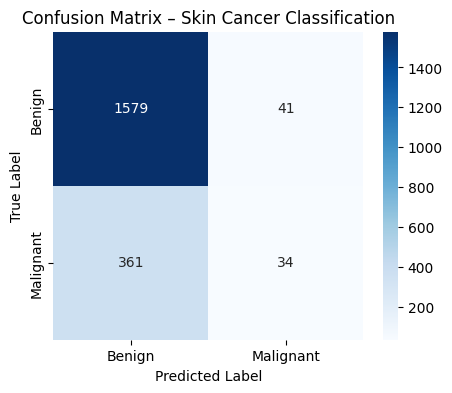

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Skin Cancer Classification")
plt.show()


The confusion matrix highlights the trade-off between false positives and false negatives.
Emphasis is placed on minimizing false negatives (missed malignant cases), which is critical in medical diagnosis.


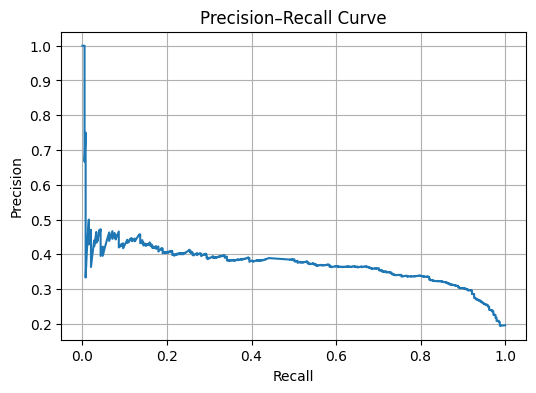

In [32]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid()
plt.show()


## Final Results
- Both CNN and Logistic Regression achieved ~80% validation accuracy.
- Accuracy alone was misleading due to strong class imbalance.
- Logistic Regression achieved higher malignant recall (0.32) but at the cost of reduced precision.
- Baseline CNN exhibited strong bias toward the benign class, missing a majority of malignant cases.
- Results highlight the importance of evaluation beyond accuracy and careful model selection in medical ML.
